# Historical Impermanent Loss
The first step in this analysis is simple looking at how much impermant loss would someone have exrienced if they had an LP position in the past and had experienced the same history.

A distribution of impermanence loss will be created and evaluated over different LP position hold times up to a year and assuming that the LP position could have been set up at any arbritary time in the past.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# load the dataframe with the historical FTMUSD price data obtained from coingecko
ftm = pd.read_pickle('ftmusd_jan2020_stationarymodified.pkl')

## What is Impermanent Loss?
Impermanent loss (IL) is the differnce between the value of an LP position of 2 assets and holding those two assets seperately in a specified ratio. As the price of the two assets diverge the value of the LP position reduces relative to holding the assets. This difference is the impermanent loss. It can be formulated or thought about in different ways.

In this analysis the LP position and ratio of assets is 1:1 (50% - 50% pool weighting) and IL is formulated as the percentage loss of value of LP versus holding.

Note that IL is different to the value of your position. You could lose almost 35% of your position equity but only experience single digit IL.

In [2]:
def get_il(ret):
    """Calculates the impermanent loss of a position after a given return.
    The return is simply the future_price/initial_price of the volatile asset
    """
    lp_value = ret**(0.5) # LP value is the sqrt of the return
    hold_value = 0.5 + 0.5*ret
    il = lp_value/hold_value
    return il

In [3]:
# Demonstration of IL, if we LP and then FTMUSD drops 60% in price
get_il(0.4) - 1

-0.09649209709474871

## Holding LP for 365 days
First a demonstration of the method. The method consists of looking at every 365-day period return possible from the historic FTMUSD data. It then builds a distribution of the returns and also a distributions of the IL expected from each return.

The statistics os the IL distribution is of most interest.

In [4]:
# Create the 365day return series from data
year_returns = ftm.price/ftm.price.shift(365)
year_returns = year_returns.dropna()

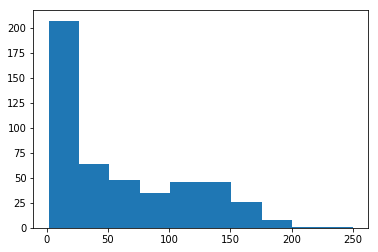

In [5]:
# Look at distribution of 365day returns of FTM
plt.hist(year_returns);

The median IL :  -0.6961826327499323
The standard deviation of IL :  0.2519089707763875


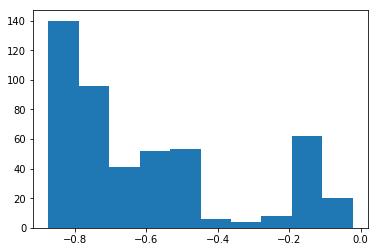

In [6]:
# get the IL of year returns and plot distribution
year_il = get_il(year_returns) - 1 
plt.hist(year_il);
print('The median IL : ',year_il.median())
print('The standard deviation of IL : ', year_il.std())

As can be seen over long time priods the distribution of returns over a full year is massively skewed to huge return numbers. This is due to the parabolic nature of early life-cycle cryptocurrencies that are still surviving.

Note: This kind of information is of little use to current LP descision making. Potential solutions to this will be implemented later.

## Holding LP position for n-days

Now the IL stats will be calculated for different holding periods of n days. From 1 day up to 365 days.

The resulting median IL is then plotted along with the standard deviation of the IL given the sample.

Historically is seems that the longer one holds an LP position the more loss one is expected to experience. But this is really a result of the historical trajectory of the price. Since its inception over the course of 3 years FTM has 100-500x it's price. The IL of assets with prices that go exponentially up or down will have this kind of look.

In [7]:
results_df = pd.DataFrame(np.zeros((365,3)),columns = ['n_days','median','std']) # df to contain results to be plotted

for n in range(1,366):
    # for each n period get the n-day returns, calculate il and save statistics
    _returns = ftm.price/ftm.price.shift(n)
    _returns = _returns.dropna()
    _il = get_il(_returns) - 1
    results_df.iloc[n-1] = [n , _il.median() , _il.std()]

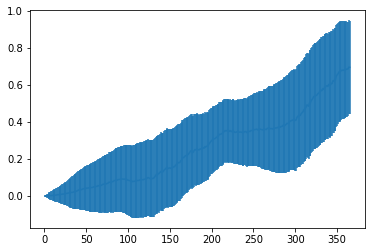

In [8]:
plt.errorbar(results_df.n_days, np.abs(results_df['median']), yerr=results_df['std']);

# Uncertainty and IL in the future

Using raw historical price of new assets like FTM has a number of issues. Every surviving cryptocurrency that has made it to top-100 in marketcap will have at some point in its history a parabolic run up in price or multiple run ups. This history is a result of it's becoming a larger marketcap. 

Once a cryptocurrency has reached a significant % of total marketcap it is unlikely to see the same price action and to infer future price movements from historic is a grave error. It is just as likely that a cryptocurrency will see a decline in price in future as it is to increase.

The future price direction and future price is completely uncertain. If we know history was to repeat than you would never create an LP position with any asset. Thus during the analysis of an LP and looking at the likely distibution of IL it is important to take a price neutral approach.

Modifying the return series to make the resulting price series station is one method to remove the price direction bias while retaining the shape distribtuion of price movements.

The notebook 'Creating_stationary_price_series' goes into the logic and modification of the series.

With this modified FTMUSD returns series we will once again run the above analysis on IL and then plot.

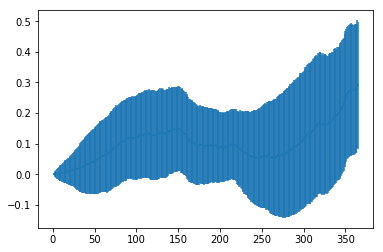

In [9]:
stationary_res_df = pd.DataFrame(np.zeros((365,3)),columns = ['n_days','median','std']) # df to contain results to be plotted

for n in range(1,366):
    # for each n period get the n-day returns, calculate il and save statistics
    _returns = ftm.mod_price/ftm.mod_price.shift(n)
    _returns = _returns.dropna()
    _il = get_il(_returns) - 1
    stationary_res_df.iloc[n-1] = [n , _il.median() , _il.std()]

plt.errorbar(stationary_res_df.n_days, np.abs(stationary_res_df['median']), yerr=stationary_res_df['std']);

This time we see a lot more reasonable graph of the median IL of holding the LP position. But even here we run into issues.

The larger the n the less data points we have for the distribution. And so the specific distribution of IL for each n is not smooth and very sample/path dependant. Unless history is to exacly repeat itself we are unlikely again to see the these sepcific emperical distributions.

# Monte-carlo Simulations

A solution to the issues put forward is creating multiple potential historical paths that the price could have taken and then looking at the distribution of IL over all possibilities.

The alternative price paths will be simulated using a bootstrap sampling method from the stationary price series. Each sample will be selected at random with replacement. This will give a very large range of possible market conditions while retaining the same historical price movement distribution and price nuetral bias.

10,000 paths will be sampled for each value of n-days. For each n-day path the IL will be calculated and again the statistics of the IL distribution for each period will be saved and plotted.

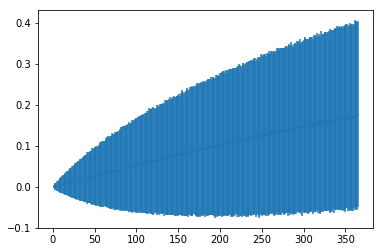

In [10]:
import random
sim_res_df = pd.DataFrame(np.zeros((365,3)),columns = ['n_days','median','std']) # df to contain results to be plotted

for n in range(1,366):
    # create 10,000 bootstrap samples
    bootstraprets = pd.DataFrame(np.zeros((n,10000)))
    for i in bootstraprets.columns:
        bootstraprets[i] = np.random.choice(ftm.mod_ret.tolist(), n)
        bootstraprets = bootstraprets.replace(to_replace=np.nan, value=1, inplace=False, limit=None, regex=False, method='pad')
    
    # for each n period get the n-day returns (product each day return), calculate il and save statistics
    _returns = bootstraprets.prod()
    _returns = _returns.dropna()
    _il = get_il(_returns) - 1
    sim_res_df.iloc[n-1] = [n , _il.median() , _il.std()]

plt.errorbar(sim_res_df.n_days, np.abs(sim_res_df['median']), yerr=sim_res_df['std']);
sim_res_df.to_pickle('il_montecarlo_ftmusd_jan2020.pkl');

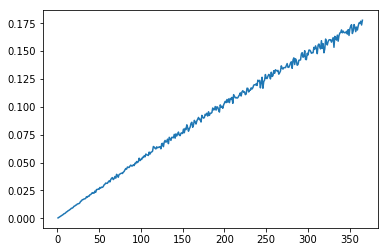

In [11]:
plt.errorbar(sim_res_df.n_days, np.abs(sim_res_df['median']));

## IL Distributions
Each set of simulations creates a distribution of the IL for each n days. The median IL of the distribtion is a good value to minimize. The standard deviation above the median is a good expected range to consider. Finally the 5th percentile is a figure that can be used as the level of risk.

In [12]:
n= 100
# create 10,000 bootstrap samples
bootstraprets = pd.DataFrame(np.zeros((n,10000)))
for i in bootstraprets.columns:
    bootstraprets[i] = np.random.choice(ftm.mod_ret.tolist(), n)
    bootstraprets = bootstraprets.replace(to_replace=np.nan, value=1, inplace=False, limit=None, regex=False, method='pad')

# for each n period get the n-day returns (product each day return), calculate il and save statistics
_returns = bootstraprets.prod()
_returns = _returns.dropna()
_il = get_il(_returns) - 1

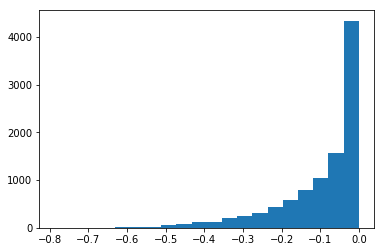

In [14]:
plt.hist(_il,bins=20);

In [43]:
np.percentile(_il,q=5)

-0.344292030932665

Median :  -0.17579000348663376
STD :  0.2275271518524533
5th percentile :  -0.695470080733572


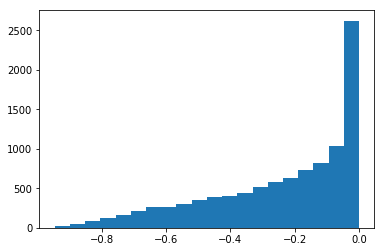

In [44]:
n= 365
# create 10,000 bootstrap samples
bootstraprets = pd.DataFrame(np.zeros((n,10000)))
for i in bootstraprets.columns:
    bootstraprets[i] = np.random.choice(ftm.mod_ret.tolist(), n)
    bootstraprets = bootstraprets.replace(to_replace=np.nan, value=1, inplace=False, limit=None, regex=False, method='pad')

# for each n period get the n-day returns (product each day return), calculate il and save statistics
_returns = bootstraprets.prod()
_returns = _returns.dropna()
_il = get_il(_returns) - 1
plt.hist(_il,bins=20);
print('Median : ',np.median(_il))
print('STD : ',np.std(_il))
print('5th percentile : ',np.percentile(_il,q=5))

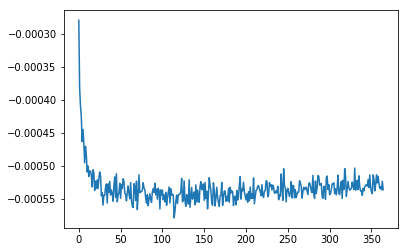

In [47]:
plt.plot((sim_res_df['median']+1)**(1/sim_res_df.n_days)-1)

In [59]:
#1/(1-(np.std(_il)-np.median(_il)))
1/(1+np.percentile(_il,q=25))

1.6759322124776135

## Approximate Return to Reach Neutral Equity
Given IL only seeks to lose money overtime in order to make creating an LP a neutral bet it required the geometric expected return of the LP to qual the geometric expected loss from IL.

The above graph indicates that the compound daily growth rate of IL for this LP is rougly -0.053%. To offset this the daily APR required is also +0.053% or 19.345% yearly APR compounded daily or 21.334% APY.

This APR is merely to break even overtime. One should look for a return larger than this to have a positive expected return and taking into account the large potential downside. A good target would be find an APR that breaks even even if the IL is 1 std above the median. This will ensure profit is 75% of the time.

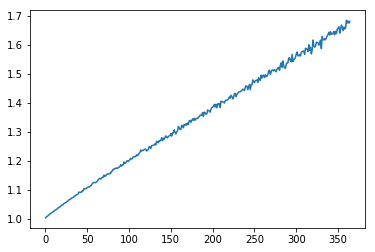

In [77]:
needed_apy = 1/(1-(sim_res_df['std']-sim_res_df['median']))
plt.plot(needed_apy);

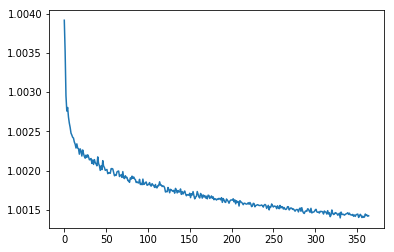

In [79]:
"""
This plots the daily return needed to achieve the above graphs APY for each n period
The plot declines showing that for longer periods of time and compounding a lower APR is needed to achieve the return"""
plt.plot(needed_apy**(1/sim_res_df.n_days));

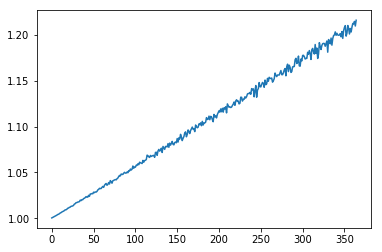

In [80]:
"""
The plots below are the same APY needed and CDGR needed but this time to break even at the median or 50%"""
median_apy = 1/(1+sim_res_df['median'])
plt.plot(median_apy);

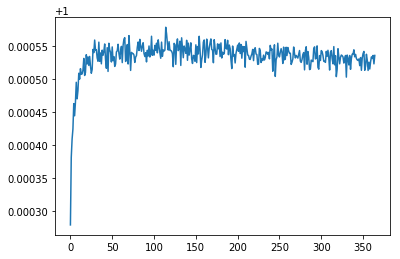

In [83]:
plt.plot(median_apy**(1/sim_res_df.n_days));

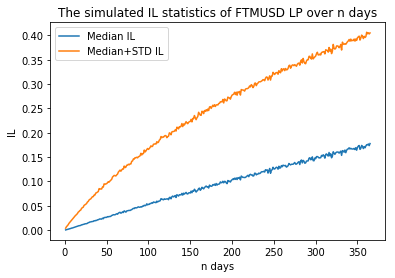

In [90]:
plt.plot(sim_res_df.n_days, -sim_res_df['median'], label = "Median IL")
plt.plot(sim_res_df.n_days, sim_res_df['std']-sim_res_df['median'], label = "Median+STD IL")
plt.xlabel('n days')
plt.ylabel('IL')
plt.title('The simulated IL statistics of FTMUSD LP over n days')
plt.legend();

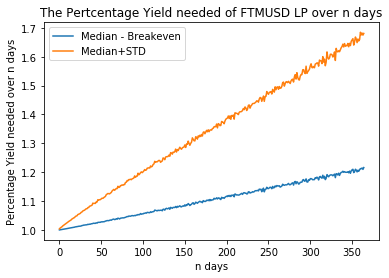

In [91]:
plt.plot(median_apy, label = "Median - Breakeven")
plt.plot(needed_apy, label = "Median+STD")
plt.xlabel('n days')
plt.ylabel('Percentage Yield needed over n days')
plt.title('The Pertcentage Yield needed of FTMUSD LP over n days')
plt.legend();

In [93]:
((1.680571**(1/365))-1)*365

0.5195029693960529

In [100]:
((median_apy.iloc[-1]**(1/365))-1)*365

0.19571999018198283